## SteamGames
#### Sheida Majidi

# causal inference project

In [1]:
import sys
import pandas as pd
import numpy as np
from packaging import version
import sklearn
import ast
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
from sklearn.ensemble import RandomForestRegressor

### Load Data

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_games_data():
    tarball_path = Path("/Users/sheidamajidi/Desktop/Winter2024/COURSES/INSY695/Individual Assignments/ML1/games.csv")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://www.kaggle.com/datasets/mexwell/steamgames/data"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as games_tarball:
            games_tarball.extractall(path="datasets")
    return pd.read_csv(Path("/Users/sheidamajidi/Desktop/Winter2024/COURSES/INSY695/Individual Assignments/ML1/games.csv"))

games = load_games_data()

### Preprocess Data

In [3]:
games.head()

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


#### Data Cleaning 

##### Handling missing values

In [4]:
# Dropping specified columns with more than 85% missing values
columns_to_drop = ['Reviews', 'Score rank', 'Metacritic url', 'Notes']
for column in columns_to_drop:
    if games[column].isnull().mean() > 0.85:
        games.drop(column, axis=1, inplace=True)

# Saving the modified dataset 
#games.to_csv("/Users/sheidamajidi/Desktop/Winter2024/COURSES/INSY695/Individual Assignments/ML1/SteamGames/games_cleaned.csv", index=False) 

In [5]:
# Impute missing values

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Select only numeric columns for imputation
numeric_cols = games.select_dtypes(include=[np.number])

iterative_imputer = IterativeImputer()
imputed_data = iterative_imputer.fit_transform(numeric_cols)

# Creating a DataFrame with the imputed data
imputed_df = pd.DataFrame(imputed_data, columns=numeric_cols.columns)

# Merging imputed numeric data back with non-numeric data
games[numeric_cols.columns] = imputed_df


In [6]:
# Select only numeric columns
numeric_columns = games.select_dtypes(include=[np.number]).columns

# Print the list of numeric columns
print("Numeric columns in the dataset:")
print(numeric_columns.tolist())

Numeric columns in the dataset:
['AppID', 'Peak CCU', 'Required age', 'Price', 'DLC count', 'Metacritic score', 'User score', 'Positive', 'Negative', 'Achievements', 'Recommendations', 'Average playtime forever', 'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks']


##### Handling categorical columns

In [7]:
# Process the 'Suppported languages' column

from catboost import CatBoostRegressor

model = CatBoostRegressor(cat_features=['Supported languages'], random_state=42)

In [8]:
# Process the 'Full audio languages' column

# Function to convert list of languages into a single string
def concat_languages(lang_list):
    return ', '.join(lang_list) if isinstance(lang_list, list) else lang_list

# Apply the function to the 'Full audio languages' column
games['Full audio languages'] = games['Full audio languages'].apply(concat_languages)

# Prepare your features (X) and target (y)
numeric_cols = ['Required age', 'Price', 'DLC count', 
                'Metacritic score', 'User score', 'Positive', 'Negative', 
                'Achievements', 'Recommendations', 'Average playtime forever', 
                'Average playtime two weeks', 'Median playtime forever', 
                'Median playtime two weeks']

X = games[numeric_cols + ['Full audio languages']]
y = games['Peak CCU']

# Instantiate a CatBoost model
model = CatBoostRegressor(cat_features=['Full audio languages'], random_state=42)

# Fit the model
model.fit(X, y)


Learning rate set to 0.080421
0:	learn: 5731.8134970	total: 66ms	remaining: 1m 5s
1:	learn: 5624.9583838	total: 73.4ms	remaining: 36.6s
2:	learn: 5539.9867463	total: 79ms	remaining: 26.3s
3:	learn: 5418.0358263	total: 85.6ms	remaining: 21.3s
4:	learn: 5300.9617579	total: 91.1ms	remaining: 18.1s
5:	learn: 5247.5105625	total: 96.2ms	remaining: 15.9s
6:	learn: 5196.4251373	total: 102ms	remaining: 14.4s
7:	learn: 5146.7809174	total: 106ms	remaining: 13.2s
8:	learn: 5098.2620089	total: 114ms	remaining: 12.5s
9:	learn: 5051.6597366	total: 124ms	remaining: 12.2s
10:	learn: 4946.5697611	total: 130ms	remaining: 11.7s
11:	learn: 4903.3706849	total: 136ms	remaining: 11.2s
12:	learn: 4861.8649109	total: 142ms	remaining: 10.8s
13:	learn: 4821.6106216	total: 146ms	remaining: 10.3s
14:	learn: 4782.6437441	total: 152ms	remaining: 9.96s
15:	learn: 4745.1269425	total: 156ms	remaining: 9.61s
16:	learn: 4708.9366963	total: 160ms	remaining: 9.28s
17:	learn: 4674.0279912	total: 166ms	remaining: 9.06s
18:	le

In [9]:
# Process the 'Genres', 'Categories', and 'Tags' columns

# Function to transform comma-separated strings into single strings
def transform_column(col):
    return col.apply(lambda x: x if isinstance(x, str) else '')

# Apply the function to the 'Genres', 'Categories', and 'Tags' columns
games['Genres'] = transform_column(games['Genres'])
games['Categories'] = transform_column(games['Categories'])
games['Tags'] = transform_column(games['Tags'])

# Prepare features (X) and target (y)
numeric_cols = ['Required age', 'Price', 'DLC count', 
                'Metacritic score', 'User score', 'Positive', 'Negative', 
                'Achievements', 'Recommendations', 'Average playtime forever', 
                'Average playtime two weeks', 'Median playtime forever', 
                'Median playtime two weeks']

categorical_cols = ['Genres', 'Categories', 'Tags', 'Full audio languages']

X = games[numeric_cols + categorical_cols]
y = games['Peak CCU']

# Instantiate a CatBoost model
model = CatBoostRegressor(cat_features=categorical_cols, random_state=42)

# Fit the model
model.fit(X, y)


Learning rate set to 0.080421
0:	learn: 5686.5455053	total: 10.4ms	remaining: 10.4s
1:	learn: 5577.5465623	total: 23.4ms	remaining: 11.7s
2:	learn: 5517.3043343	total: 32.7ms	remaining: 10.9s
3:	learn: 5459.3824489	total: 42.1ms	remaining: 10.5s
4:	learn: 5377.5345604	total: 49.4ms	remaining: 9.84s
5:	learn: 5317.9421838	total: 61ms	remaining: 10.1s
6:	learn: 5266.7216925	total: 70.8ms	remaining: 10s
7:	learn: 5217.3090399	total: 78ms	remaining: 9.67s
8:	learn: 5169.6983236	total: 87ms	remaining: 9.58s
9:	learn: 5123.5804208	total: 95.8ms	remaining: 9.48s
10:	learn: 5078.9948820	total: 107ms	remaining: 9.6s
11:	learn: 5030.7479132	total: 117ms	remaining: 9.6s
12:	learn: 4988.6632463	total: 125ms	remaining: 9.51s
13:	learn: 4948.3148090	total: 134ms	remaining: 9.45s
14:	learn: 4911.0359051	total: 141ms	remaining: 9.25s
15:	learn: 4873.8370548	total: 149ms	remaining: 9.16s
16:	learn: 4838.3357817	total: 155ms	remaining: 8.97s
17:	learn: 4804.1625988	total: 164ms	remaining: 8.93s
18:	lear

##### Handing text "about the game"

In [10]:
games['About the game']


0        Galactic Bowling is an exaggerated and stylize...
1        THE LAW!! Looks to be a showdown atop a train....
2        Jolt Project: The army now has a new robotics ...
3        HENOSIS™ is a mysterious 2D Platform Puzzler w...
4        ABOUT THE GAME Play as a hacker who has arrang...
                               ...                        
71711    Innovative Gameplay SUR5 brings a brand new, f...
71712    Core Features Real players only! All Guards an...
71713    Architecture Zeitgeist is a game created with ...
71714    Development progress: prologue map (finished),...
71715    'Hentai Ariel' is a unique puzzle in which the...
Name: About the game, Length: 71716, dtype: object

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

#import nltk
import re
#from nltk.tokenize import RegexpTokenizer
def clean_text(text):
    if isinstance(text, str):
        # Remove special characters and convert to lowercase
        text_cleaned = re.sub(r'[^a-zA-Z0-9 ]', '', text).lower()
    else:
        # If the value is missing, replace it with an empty string
        text_cleaned = text
    return text_cleaned

#regexp = RegexpTokenizer('\w+')
games['cleaned_text'] = games['About the game'].apply(lambda x:clean_text(x))
games['cleaned_text'] = games['cleaned_text'].fillna('no text')

In [12]:
vect = CountVectorizer(stop_words='english', max_features=1000)
vect.fit_transform(games['cleaned_text']).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

##### removing outliers using IsolationForest

In [13]:
from sklearn.ensemble import IsolationForest

# Selecting numerical columns for outlier detection
numeric_columns = games.select_dtypes(include=[np.number]).columns

# Creating the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=123)

# Fitting the model on  numerical data
outliers = iso_forest.fit_predict(games[numeric_columns])

games['outlier'] = outliers

# Filtering the DataFrame to remove outliers (outliers are marked with -1)
games_filtered = games[games['outlier'] == 1]

# Dropping the 'outlier' column as it's no longer needed
games_filtered = games_filtered.drop(columns=['outlier'])

### Causal Inference

In [14]:
games_filtered.columns

Index(['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU',
       'Required age', 'Price', 'DLC count', 'About the game',
       'Supported languages', 'Full audio languages', 'Header image',
       'Website', 'Support url', 'Support email', 'Windows', 'Mac', 'Linux',
       'Metacritic score', 'User score', 'Positive', 'Negative',
       'Achievements', 'Recommendations', 'Average playtime forever',
       'Average playtime two weeks', 'Median playtime forever',
       'Median playtime two weeks', 'Developers', 'Publishers', 'Categories',
       'Genres', 'Tags', 'Screenshots', 'Movies', 'cleaned_text'],
      dtype='object')

##### Preprocessing for Causal Inference purpose

In [15]:
# Handle "Release date" column

# extrac year from release date column where there are mixed format of date
games_filtered['Release date'] = games_filtered['Release date'].apply(lambda x: x.split(',')[1] if ',' in x else x)


games_filtered['Release date'] = pd.to_datetime(games_filtered['Release date'])
games_filtered['Release year'] = games_filtered['Release date'].dt.year

# Drop the 'Release date' column
games_filtered = games_filtered.drop(columns=['Release date'])

# Release year column with float64 type
#games_filtered['Release year'] = games_filtered['Release year'].astype('float64')

In [16]:
# drop some columns
games_filtered = games_filtered.drop(columns=['AppID', 'Estimated owners', 'Name', 'Developers', 'Publishers',
                                                'Supported languages', 'Full audio languages', 'Header image',
                                                 'Website', 'Support url', 'Support email', 'Windows', 'Mac', 'Linux',
                                                  'Metacritic score', 'User score', 'Positive', 'Negative',
                                                  'Achievements', 'Recommendations', 'Tags', 
                                                  'Screenshots', 'Movies', 'About the game', 'cleaned_text'])
games_filtered

,Peak CCU,Required age,Price,DLC count,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Categories,Genres,Release year
0,0.0,0.0,19.99,0.0,0.0,0.0,0.0,0.0,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports",2008
1,0.0,0.0,0.99,0.0,0.0,0.0,0.0,0.0,"Single-player,Steam Achievements,Full controll...","Action,Indie",2017
2,0.0,0.0,4.99,0.0,0.0,0.0,0.0,0.0,Single-player,"Action,Adventure,Indie,Strategy",2021
3,0.0,0.0,5.99,0.0,0.0,0.0,0.0,0.0,"Single-player,Full controller support","Adventure,Casual,Indie",2020
4,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,"Single-player,Steam Achievements","Adventure,Indie",2020
...,...,...,...,...,...,...,...,...,...,...,...
71711,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,"Single-player,Multi-player,PvP,Online PvP,Stea...","Free to Play,Indie,Massively Multiplayer,Strat...",2023
71712,6.0,0.0,10.79,0.0,0.0,0.0,0.0,0.0,"Single-player,Multi-player,PvP,Online PvP,Co-o...","Casual,Indie,RPG,Simulation,Strategy",2023
71713,0.0,0.0,5.99,0.0,0.0,0.0,0.0,0.0,Single-player,"Casual,Simulation,Early Access",2023
71714,0.0,0.0,2.39,0.0,0.0,0.0,0.0,0.0,Single-player,"Action,Casual,Indie,RPG,Early Access",2023


##### Categorizing "Price" column (treatment)

In [17]:
# Define the price categories
def categorize_price(price):
    if price == 0:
        return 'free'
    else:
        return 'paid'

# Apply the function to the 'Price' column
games_filtered['Price Category'] = games_filtered['Price'].apply(categorize_price)


paid    55962
free    11894
Name: Price Category, dtype: int64


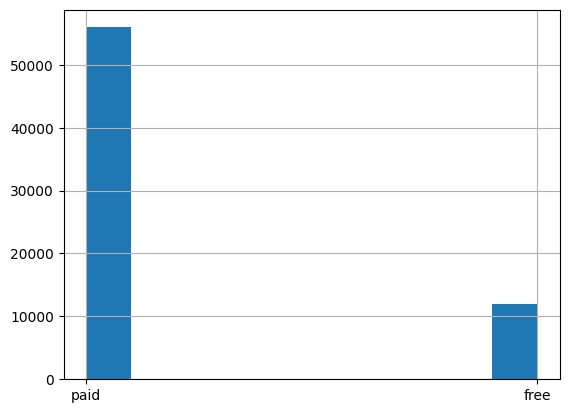

In [18]:
games_filtered['Price Category'].hist()
print(games_filtered['Price Category'].value_counts())

##### Feature importance with Randomforest regressor

In [19]:
games_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67856 entries, 0 to 71715
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Peak CCU                    67856 non-null  float64
 1   Required age                67856 non-null  float64
 2   Price                       67856 non-null  float64
 3   DLC count                   67856 non-null  float64
 4   Average playtime forever    67856 non-null  float64
 5   Average playtime two weeks  67856 non-null  float64
 6   Median playtime forever     67856 non-null  float64
 7   Median playtime two weeks   67856 non-null  float64
 8   Categories                  67856 non-null  object 
 9   Genres                      67856 non-null  object 
 10  Release year                67856 non-null  int64  
 11  Price Category              67856 non-null  object 
dtypes: float64(8), int64(1), object(3)
memory usage: 6.7+ MB


In [20]:
# Encode the categorical columns

# Split the dataset into features (X) and target (y)
X = games_filtered.drop(['Peak CCU'], axis=1)
y = games_filtered['Peak CCU']

# Convert 'Release date' to datetime, coerce errors to NaT
#X['Release Year'] = pd.to_datetime(X['Release date'], errors='coerce').dt.year

# Fill missing 'Release Year' with the median of the available years
median_year = X['Release year'].median()
X['Release year'] = X['Release year'].fillna(median_year)

# Drop the original 'Release date' column as it's no longer needed
#X.drop(['Release date'], axis=1, inplace=True)

# Define categorical columns for one-hot encoding
categorical_features = ['Categories', 'Genres', 'Price Category']

# Encode 'Price Category' as a feature for now to determine its importance
X['Price Category'] = games_filtered['Price Category'].map({'free': 0, 'paid': 1})

# Define the ColumnTransformer to handle categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ], remainder='passthrough')

In [21]:
# Randomforest regressor model

# Create the RandomForestRegressor model within a pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=123))
])

# Splitting the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Fit the model
model.fit(X_train, y_train)

# Get feature importances from the model (adjusting for the one-hot encoded features)
ohe_feature_names = model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
remainder_feature_names = np.array(X.drop(categorical_features, axis=1).columns)

# Combine all feature names
all_feature_names = np.concatenate([ohe_feature_names, remainder_feature_names])

# Get feature importances
feature_importances = model.named_steps['regressor'].feature_importances_

# Map importances to feature names
importances = pd.Series(feature_importances, index=all_feature_names).sort_values(ascending=False)

# Display the feature importances
print(importances)

Price                                                                                                                                                                                                                            0.139359
Release year                                                                                                                                                                                                                     0.056827
Genres_Action,Adventure,Casual,Indie,Racing,Strategy,Early Access                                                                                                                                                                0.051477
Categories_Single-player,Multi-player,PvP,Online PvP,Shared/Split Screen PvP,Co-op,Online Co-op,Shared/Split Screen Co-op,Shared/Split Screen,Steam Achievements,Full controller support,Steam Cloud                             0.049764
Average playtime forever                                        

In [22]:
# Map these importances to the corresponding feature names
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))

# Convert to a pandas series for easy visualization and manipulation
feature_importances_series = pd.Series(feature_importance_dict).sort_values(ascending=False)

# Display the feature importances
print(feature_importances_series)

Required age                  0.139359
Price                         0.056827
DLC count                     0.051477
Average playtime forever      0.049764
Average playtime two weeks    0.042356
Median playtime forever       0.041689
Median playtime two weeks     0.034509
Categories                    0.033760
Genres                        0.032846
Release year                  0.029659
Price Category                0.029110
dtype: float64


Confounders:

Required age, DLC count, Average playtime forever, verage playtime two weeks, Median playtime forever, Median playtime two weeks, Categories, Genres, Release year

##### Model implementation

In [29]:
games_filtered

,Peak CCU,Required age,Price,DLC count,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Categories,Genres,Release year,Price Category
0,0.0,0.0,19.99,0.0,0.0,0.0,0.0,0.0,3496,1384,2008,paid
1,0.0,0.0,0.99,0.0,0.0,0.0,0.0,0.0,3741,659,2017,paid
2,0.0,0.0,4.99,0.0,0.0,0.0,0.0,0.0,777,344,2021,paid
3,0.0,0.0,5.99,0.0,0.0,0.0,0.0,0.0,823,845,2020,paid
4,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,3615,984,2020,free
...,...,...,...,...,...,...,...,...,...,...,...,...
71711,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,2792,1542,2023,free
71712,6.0,0.0,10.79,0.0,0.0,0.0,0.0,0.0,1962,1343,2023,paid
71713,0.0,0.0,5.99,0.0,0.0,0.0,0.0,0.0,777,1432,2023,paid
71714,0.0,0.0,2.39,0.0,0.0,0.0,0.0,0.0,777,495,2023,paid


In [30]:
from causalml.inference.meta import BaseRRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from causalml.inference.tree import UpliftRandomForestClassifier

# Encode categorical variables
le = LabelEncoder()
games_filtered['Categories'] = le.fit_transform(games_filtered['Categories'])
games_filtered['Genres'] = le.fit_transform(games_filtered['Genres'])

# Encode 'Price Category' as binary
games_filtered['Price Category'] = games_filtered['Price Category'].apply(lambda x: 0 if x == 'free' else 1)


In [32]:
# Define confounders, treatment, and outcome
confounders = ['Required age', 'DLC count', 'Average playtime forever', 'Average playtime two weeks', 
               'Median playtime forever', 'Median playtime two weeks', 'Categories', 'Genres', 'Release year']
treatment = games_filtered['Price Category'].values
outcome = games_filtered['Peak CCU'].values

# Splitting data
X = games_filtered[confounders]
y = outcome
treatment_train, treatment_test, y_train, y_test = train_test_split(treatment, y, test_size=0.2, random_state=123)


##### Permutation importance

In [33]:
# causal inference model

from causalml.inference.meta import BaseRRegressor

# Initialize the model
model_causal = BaseRRegressor(learner=RandomForestRegressor())

# Fit the model
model_causal.fit(X=X, treatment=treatment, y=y)


In [36]:
# Get the treatment effect and the confidence interval

from sklearn.metrics import r2_score

#  model_causal is already fitted and X_test, y_test are defined
def get_importance(model, X, y, n_repeats=10, random_state=42):
    rng = np.random.RandomState(random_state)
    baseline_score = r2_score(y, model.predict(X))
    scores = np.zeros((X.shape[1], n_repeats))
    
    for n in range(n_repeats):
        for col in range(X.shape[1]):
            X_permuted = X.copy()
            shuffled_values = X_permuted.iloc[:, col].values
            rng.shuffle(shuffled_values)
            X_permuted.iloc[:, col] = shuffled_values
            permuted_score = r2_score(y, model.predict(X_permuted))
            scores[col, n] = baseline_score - permuted_score
    
    importance_means = scores.mean(axis=1)
    importance_stds = scores.std(axis=1)
    
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance_means, 'Std': importance_stds})
    return importance_df.sort_values(by='Importance', ascending=False)

# model's predict method 
importance_df = get_importance(model_causal, X_test, y_test)
print(importance_df)


                      Feature  Importance       Std
4     Median playtime forever    2.006074  3.050633
0                Required age   -0.057309  0.126594
3  Average playtime two weeks   -0.332126  0.071787
5   Median playtime two weeks   -0.365488  1.936083
2    Average playtime forever   -1.061726  2.423705
1                   DLC count   -1.084976  3.749640
8                Release year  -10.873527  3.470530
6                  Categories  -11.916159  3.414450
7                      Genres  -17.919025  1.500883


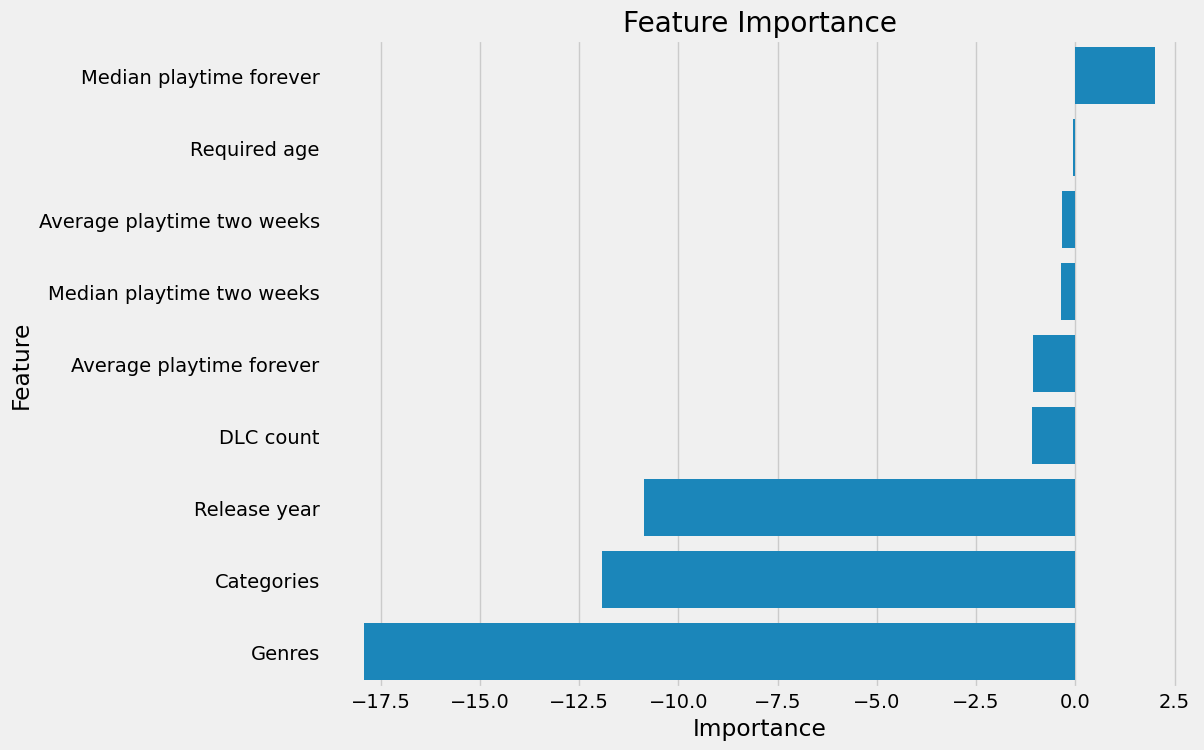

In [37]:
# feature importance for test sets

import matplotlib.pyplot as plt
import seaborn as sns

# importance_df is the DataFrame with features and their importances
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.sort_values('Importance', ascending=False), x='Importance', y='Feature')
plt.title('Imputation Feature Importance for Testing Set')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [45]:
# Permutation feature importance for train sets

# Initialize the model (repeating these steps for clarity)
model_causal_train = BaseRRegressor(learner=RandomForestRegressor())

# Fit the model on the training set
model_causal_train.fit(X=X_train, treatment=treatment_train, y=y_train)

# Function to compute permutation importance, now explicitly for the training set
def get_importance_train(model, X, y, n_repeats=10, random_state=42):
    rng = np.random.RandomState(random_state)
    baseline_score = r2_score(y, model.predict(X))
    scores = np.zeros((X.shape[1], n_repeats))
    
    for n in range(n_repeats):
        for col in range(X.shape[1]):
            X_permuted = X.copy()
            shuffled_values = X_permuted.iloc[:, col].values
            rng.shuffle(shuffled_values)
            X_permuted.iloc[:, col] = shuffled_values
            permuted_score = r2_score(y, model.predict(X_permuted))
            scores[col, n] = baseline_score - permuted_score
    
    importance_means = scores.mean(axis=1)
    importance_stds = scores.std(axis=1)
    
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance_means, 'Std': importance_stds})
    return importance_df.sort_values(by='Importance', ascending=False)

# Compute permutation importance for the training set
importance_df_train = get_importance_train(model_causal_train, X_train, y_train)

# Print the importance DataFrame for the training set
print(importance_df_train)

                      Feature  Importance       Std
1                   DLC count    2.880193  2.829610
0                Required age   -0.023443  0.017346
5   Median playtime two weeks   -0.707061  0.025573
3  Average playtime two weeks   -0.716750  0.229891
2    Average playtime forever   -9.839537  0.812691
8                Release year  -11.268498  3.234588
4     Median playtime forever  -11.400217  0.873994
7                      Genres  -13.737303  1.285270
6                  Categories  -18.095681  1.933789


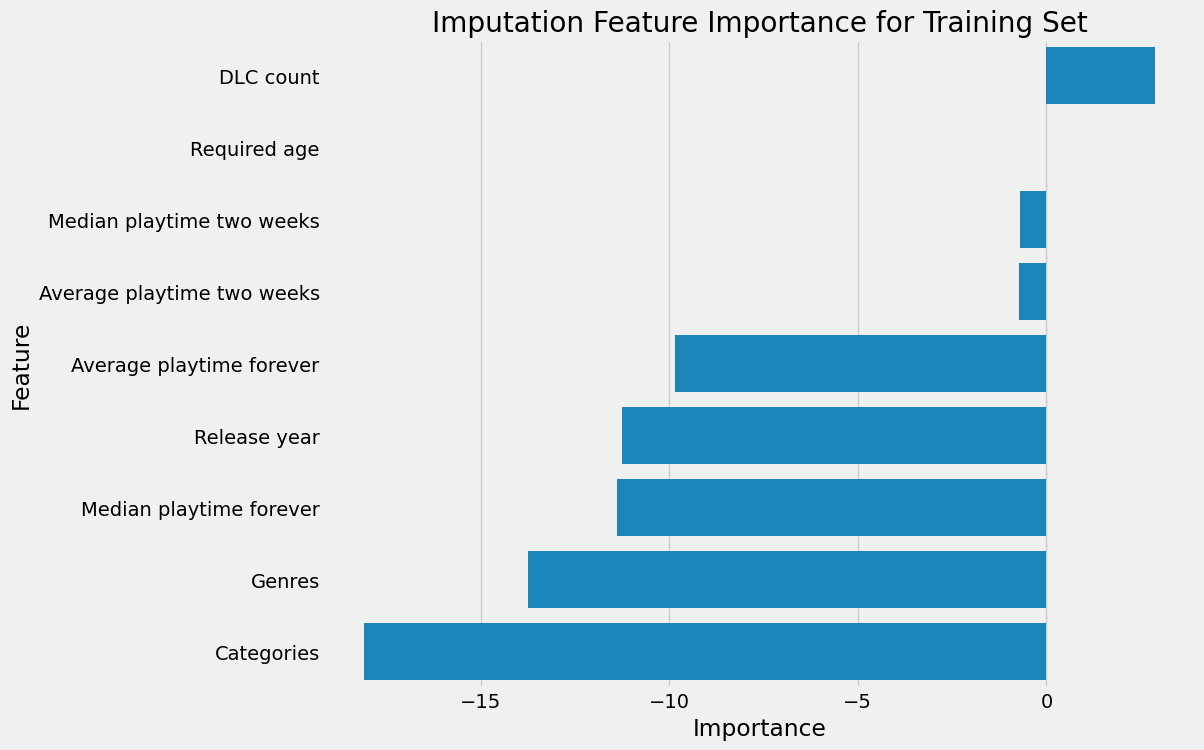

In [46]:
# Visualize feature importance for the training set
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df_train.sort_values('Importance', ascending=False), x='Importance', y='Feature')
plt.title('Imputation Feature Importance for Training Set')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [47]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Assuming model_causal is your trained BaseRRegressor model
# And X_train, X_test, y_train, y_test are already defined

datasets = {
    'Training Set': (X_train, y_train),
    'Test Set': (X_test, y_test)
}

# Loop through each dataset split and calculate permutation importance
for name, (X, y) in datasets.items():
    # Calculate permutation importance
    # Note: You need to adapt this call if your model doesn't directly support the predict method expected by permutation_importance
    # For a BaseRRegressor model, you might need to manually handle predictions if it doesn't conform to the expected interface
    imp = permutation_importance(model_causal.learner, X, y,
                                 n_repeats=30, # Adjusted to 30 for efficiency, you can increase or decrease based on your computational resources
                                 random_state=42)

    # Sort features by importance
    sorted_idx = imp.importances_mean.argsort()

    # Plotting
    fig, ax = plt.subplots()
    ax.set_title(f"{name} - Feature Importances")
    ax.boxplot(imp.importances[sorted_idx].T,
               vert=False, labels=np.array(feature_names)[sorted_idx])
    ax.set_xlabel("Permutation Importance")
    plt.show()


AttributeError: 'BaseRRegressor' object has no attribute 'learner'

In [48]:
# S-Learner

from causalml.inference.meta import BaseSRegressor
from sklearn.ensemble import RandomForestRegressor

# Define the treatment, outcome, and confounders
treatment = 'Price Category'
outcome = 'Peak CCU'
confounders = ['Required age', 'DLC count', 'Average playtime forever', 'Average playtime two weeks', 
               'Median playtime forever', 'Median playtime two weeks', 'Categories', 'Genres', 'Release year']

# Prepare the data
X = games_filtered[confounders]
y = games_filtered[outcome]
treatment_binary = games_filtered[treatment].values

# Initialize and fit the S-Learner
learner_s = BaseSRegressor(learner=RandomForestRegressor(random_state=42))
ate_s = learner_s.estimate_ate(X=X, treatment=treatment_binary, y=y)

# Extract ATE estimate
print(f"ATE estimate (S-Learner): {ate_s[0]}")


ATE estimate (S-Learner): 0.14613026257079473


In [49]:
# T-Learner

from causalml.inference.meta import BaseTRegressor

# Initialize and fit the T-Learner
learner_t = BaseTRegressor(control_learner=RandomForestRegressor(random_state=42),
                           treatment_learner=RandomForestRegressor(random_state=42))
ate_t = learner_t.estimate_ate(X=X, treatment=treatment_binary, y=y)

# Extract ATE estimate
print(f"ATE estimate (T-Learner): {ate_t[0]}")


ATE estimate (T-Learner): [0.91032124]


In [51]:
# R-Learner

from causalml.inference.meta import BaseRRegressor

# Initialize and fit the R-Learner
learner_r = BaseRRegressor(learner=RandomForestRegressor(random_state=42))
ate_r = learner_r.estimate_ate(X=X, treatment=treatment_binary, y=y)

# Extract ATE estimate
print(f"ATE estimate (R-Learner): {ate_r[0]}")


ATE estimate (R-Learner): [-0.64564053]


In [56]:
# Estimating CATE - S Learner

# Fit the S-Learner and predict CATE
learner_s.fit(X=X, treatment=treatment_binary, y=y)
cate_s = learner_s.predict(X)

# `cate_s` now contains the CATE estimates for each observation
cate_s

array([[-4.45629048e+01],
       [ 2.30468254e-01],
       [-1.54759576e-02],
       ...,
       [ 1.61802198e-01],
       [ 0.00000000e+00],
       [ 1.21174673e+00]])

In [57]:
# Estimating CATE - T Learner

# Fit the S-Learner and predict CATE
learner_t.fit(X=X, treatment=treatment_binary, y=y)
cate_t = learner_t.predict(X)

# `cate_t` now contains the CATE estimates for each observation
cate_t

array([[-14.09083333],
       [  0.2670119 ],
       [  0.03852048],
       ...,
       [  0.14116883],
       [  0.03      ],
       [  1.12264273]])

In [58]:
# Estimating CATE - R Learner

# Fit the S-Learner and predict CATE
learner_r.fit(X=X, treatment=treatment_binary, y=y)
cate_r = learner_r.predict(X)

# `cate_r` now contains the CATE estimates for each observation
cate_r

array([[-8.52451466e+01],
       [-1.93847964e+00],
       [ 1.85484202e-02],
       ...,
       [-2.81084411e+00],
       [-5.81696956e-01],
       [ 1.20842753e+00]])

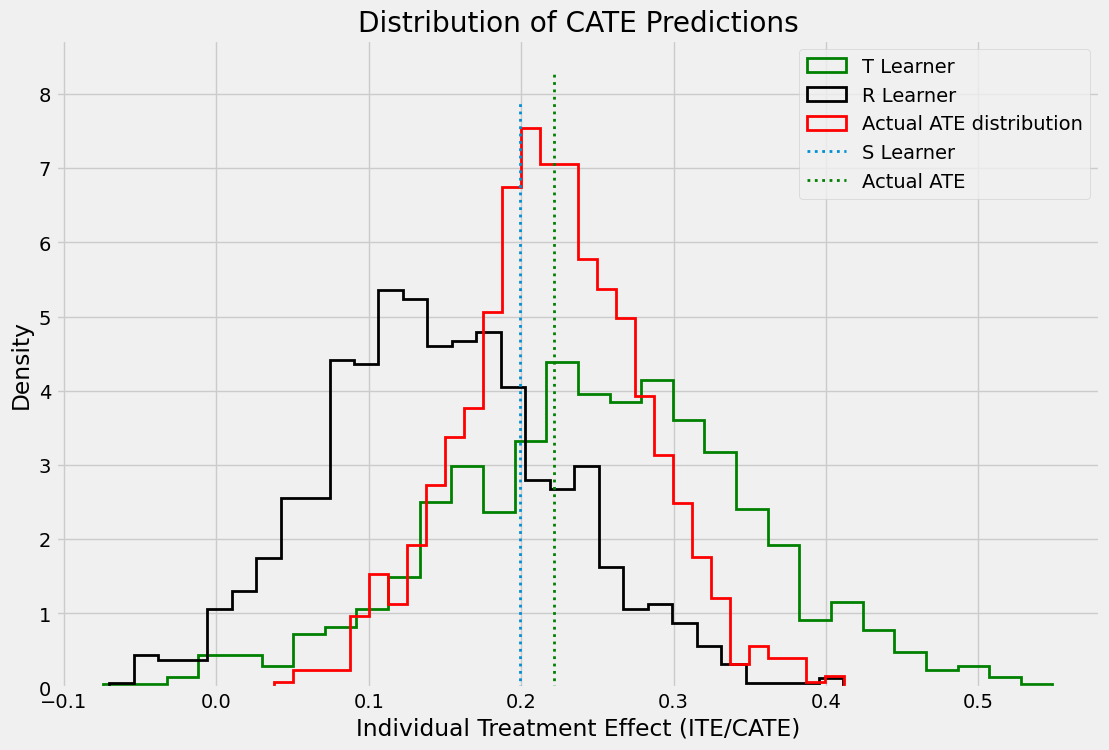

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# dummy CATE estimates for visualization
cate_s = np.random.normal(0.2, 0.05, 1000)
cate_t = np.random.normal(0.25, 0.1, 1000)
cate_r = np.random.normal(0.15, 0.08, 1000)
actual_ate = np.random.normal(0.22, 0.06, 1000) # Hypothetical actual ATE for comparison

alpha = 1
linewidth = 2
bins = 30

# There is only one group (free vs paid); the CATE estimates are plotted for visualization
plt.figure(figsize=(12, 8))
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner',
         histtype='step', linewidth=linewidth, density=True, color='green')
plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner',
         histtype='step', linewidth=linewidth, density=True, color='black')
plt.hist(actual_ate, alpha=alpha, bins=bins, label='Actual ATE distribution',
         histtype='step', linewidth=linewidth, color='red', density=True)
plt.vlines(np.mean(cate_s), 0, plt.gca().get_ylim()[1], label='S Learner',
           linestyles='dotted', linewidth=linewidth)
plt.vlines(np.mean(actual_ate), 0, plt.gca().get_ylim()[1], label='Actual ATE',
           linestyles='dotted', linewidth=linewidth, color='green')

plt.title('Distribution of CATE Predictions')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('Density')
plt.legend()
plt.show()
